In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.neighbors import KernelDensity

import glob
from PIL import Image

from sklearn.mixture import GaussianMixture
import statsmodels.api as sm

sns.set()

In [2]:
def mixture(x):
    mix = (
        1 / (2 * np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2) + 
        0.25 * np.exp(-(x + 2)) * (x >= -2) + 
        0.25 * np.exp(-(-x + 2)) * (x <= 2)
    )
    
    return mix

def drawn_mixture(n):    
    norm = np.random.normal(0, 1, n)
    u = np.random.rand(n)

    mixture = np.random.choice(3, n, p=[0.5, 0.25, 0.25])

    mask_norm = mixture == 0
    mask_e1 = mixture == 1
    mask_e2 = mixture == 2
    
    e1 = (-2 - np.log(1 - u))
    e2 = (2 + np.log(1 - u))

    X = norm * mask_norm + e1 * mask_e1 + e2 * mask_e2
    
    return X

def MISE(values, shared_bins, Q):
    x = np.linspace(-3, 3, Q)
    idx = np.arange(len(shared_bins))
    approx_hist = []
    for elem in x:
        ge_mask = shared_bins >= elem
        le_mask = shared_bins <= elem

        if all(~le_mask):
            l = 0
        elif all(le_mask):
            l = idx[-2]
        else:
            l = idx[le_mask][-1]
            
        approx_hist.append(values[l])
        
    return 6 / Q * np.sum((np.array(approx_hist) - mixture(x))**2)

# Task 1

## Download data

In [17]:
data = pd.read_csv("data/LakeHuron.txt")
data.rename(columns={"x": "water_rate"}, inplace=True)
data["water_rate"] = data["water_rate"].apply(lambda x: x.split("\t")[1]).astype(float)
data.head()

,water_rate
0,580.38
1,581.86
2,580.97
3,580.80
4,579.79


In [51]:
def normal(x, mu, sigma):
    return 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(- (x - mu)**2 / (2 * sigma**2))

def create_gif(fp_in, fp_out):
    img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
    img.save(fp=fp_out, format='GIF', append_images=imgs, 
             save_all=True, duration=500, loop=0)

## Plot Normal estimated PDF and histogram with Sturges rule 

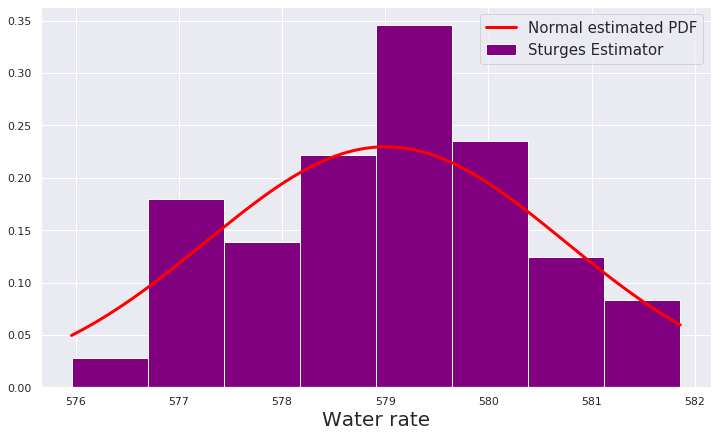

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

n = 100
x = np.linspace(data["water_rate"].min(), data["water_rate"].max(), n)
mu = data["water_rate"].mean()
sigma = data["water_rate"].var()
_ = ax.hist(data["water_rate"], bins="sturges", color="purple", density=True, label="Sturges Estimator")
ax.plot(x, normal(x, mu, sigma), color="red", linewidth=3, label="Normal estimated PDF")
ax.set_xlabel("Water rate", fontsize=20)
ax.legend(fontsize=15)

# fig.savefig("Images/Task1_1.png", dpi=300)

## GIF representaion of bias-variance tradeoff

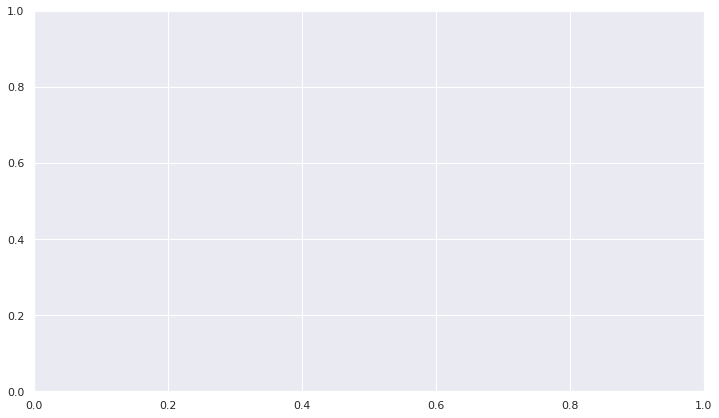

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

n = 100
x = np.linspace(data["water_rate"].min(), data["water_rate"].max(), n)
mu = data["water_rate"].mean()
sigma = data["water_rate"].var()

for h in range(5, 31):
    _ = ax.hist(data["water_rate"], bins=h, color="purple", density=True, label="h = {}".format(h))
    ax.plot(x, normal(x, mu, sigma), color="red", linewidth=3, label="Normal estimated PDF")
    ax.set_xlabel("Water rate", fontsize=20)
    ax.set_ylim([0, 0.5])
    ax.legend(fontsize=12, loc="upper left")

    fig.savefig("Images/GIF_Images/image_{}.png".format(h))
    ax.clear()

In [97]:
def create_gif(fp_in, fp_out):
    img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
    img.save(fp=fp_out, format='GIF', append_images=imgs, 
             save_all=True, duration=500, loop=0)

fp_in = "Images/GIF_Images/image_*.png"
fp_out = "Images/Task1_2.gif"
create_gif(fp_in, fp_out)

## Plot all accessible kernels

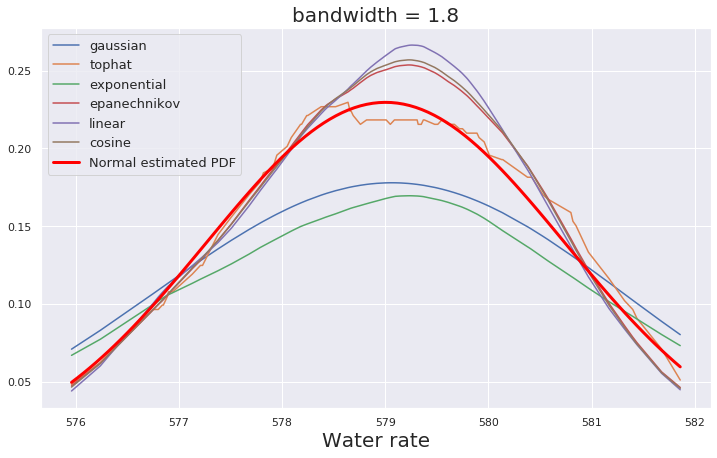

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
kernels = ["gaussian", "tophat", "exponential", "epanechnikov", "linear", "cosine"]

bandwidth = 1.8
X = np.sort(data["water_rate"].values)
for kernel in kernels:
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(X[:, None])
    dens = np.exp(kde.score_samples(X[:, None]))
    ax.plot(X, dens, label=kernel)
    
ax.plot(x, normal(x, mu, sigma), color="red", linewidth=3, label="Normal estimated PDF")
ax.set_xlabel("Water rate", fontsize=20)
ax.set_title("bandwidth = {}".format(bandwidth), fontsize=20)
ax.legend(fontsize=13, loc="upper left")
# fig.savefig("Images/Task1_3.png", dpi=300)

## Show different bandwidth 

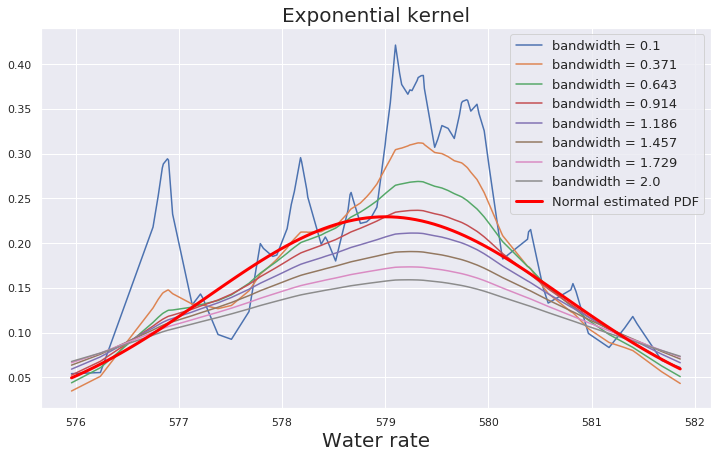

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

bandwidth
X = np.sort(data["water_rate"].values)
for bandwidth in np.linspace(0.1, 2, 8):
    kde = KernelDensity(kernel="exponential", bandwidth=bandwidth).fit(X[:, None])
    dens = np.exp(kde.score_samples(X[:, None]))
    ax.plot(X, dens, label="bandwidth = {}".format(round(bandwidth, 3)))
    
ax.plot(x, normal(x, mu, sigma), color="red", linewidth=3, label="Normal estimated PDF")
ax.set_xlabel("Water rate", fontsize=20)
ax.set_title("Exponential kernel", fontsize=20)
ax.legend(fontsize=13, loc="upper right")
# fig.savefig("Images/Task1_4.png", dpi=300)

# Task 2

## Plot histogram using Freedman Diaconis Estimator

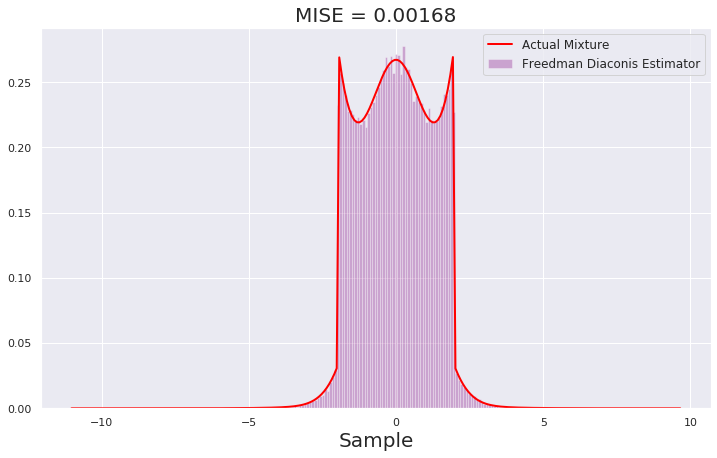

In [165]:
n = 100000
X = drawn_mixture(n)
shared_bins = np.histogram_bin_edges(X, bins="fd")

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
values, _, _ = ax.hist(X, bins=shared_bins, density=True, 
                       color="purple", alpha=0.3, label="Freedman Diaconis Estimator")
ax.plot(shared_bins, mixture(shared_bins), color="red", linewidth=2, label="Actual Mixture")
ax.set_xlabel("Sample", fontsize=20)
ax.set_title("MISE = {}".format(round(MISE(values, shared_bins, Q=10000), 5)), fontsize=20)
ax.legend(fontsize=12)
# fig.savefig("Images/Task2_1.png", dpi=300)

## Plot different bin edge estimators

In [66]:
n = 100000
J = 100

dict_MISE = dict()
estimators = ["auto", "fd", "doane", "scott", "stone", "rice", "sturges", "sqrt"]

for estim in tqdm(estimators):
    dict_MISE[estim] = []
    for i in range(J):
        X = drawn_mixture(n)
        shared_bins = np.histogram_bin_edges(X, bins=estim)
        values, _ = np.histogram(X, bins=shared_bins, density=True)
        dict_MISE[estim].append(MISE(values, shared_bins, Q=10000))

/home/vitaliy/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:661: RuntimeWarning: The number of bins estimated may be suboptimal.
  bin_edges, _ = _get_bin_edges(a, bins, range, weights)


In [68]:
# pd.DataFrame(dict_MISE).to_csv("dict_MISE.csv")

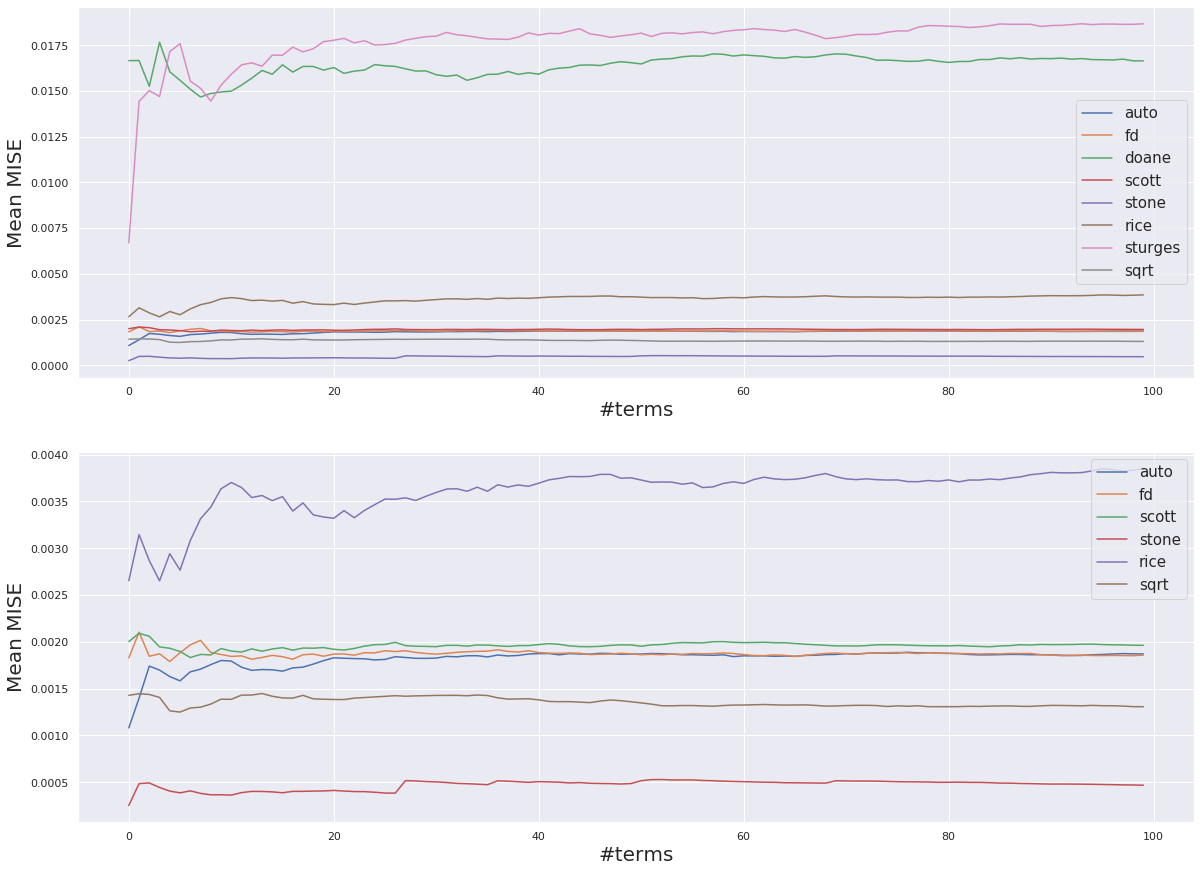

In [172]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
for estim in estimators:
    mean_MISE = np.cumsum(dict_MISE[estim]) / np.arange(1, J + 1)
    if estim != "sturges" and estim != "doane":
        ax[1].plot(mean_MISE, label=estim)
    ax[0].plot(mean_MISE, label=estim)
    
ax[0].set_xlabel("#terms", fontsize=20)
ax[0].set_ylabel("Mean MISE", fontsize=20)
ax[0].legend(fontsize=15)

ax[1].set_xlabel("#terms", fontsize=20)
ax[1].set_ylabel("Mean MISE", fontsize=20)
ax[1].legend(fontsize=15)

# fig.savefig("Images/Task2_2.png", dpi=300)

We can see that __Cross validation estimator (leave-one-out) a.k.a "stone"__ gives us the best quality in sense of MISE. Use this [article](https://numpy.org/devdocs/reference/generated/numpy.histogram_bin_edges.html) to get an acquaintance with other methods.

## Plot kernel density estimation

In [136]:
h_range = np.linspace(1e-8, 1 - 1e-8, 100)
n = 10000

X = np.sort(drawn_mixture(n))
list_MISE = []
for h in tqdm(h_range):
    kde = KernelDensity(kernel="epanechnikov", bandwidth=h).fit(X[:, None])
    dens = np.exp(kde.score_samples(X[:, None]))
    list_MISE.append(MISE((dens + np.roll(dens, 1))[1:] / 2, X, Q=10000))

100%|██████████| 100/100 [14:33<00:00,  8.73s/it]


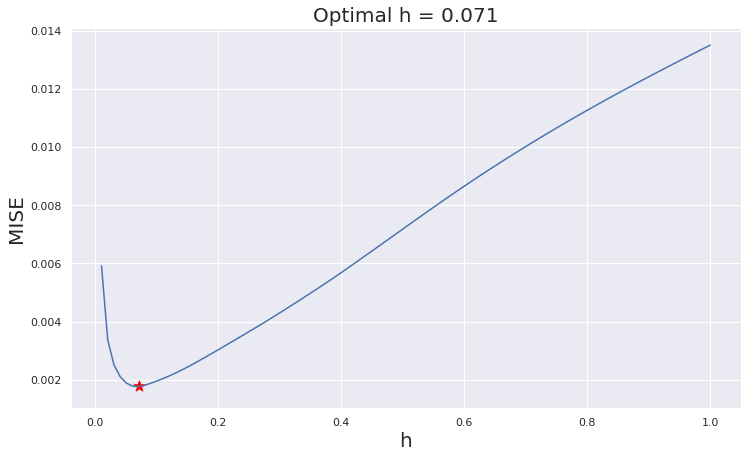

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

optim_h = h_range[np.argmin(list_MISE)]
ax.plot(h_range[1:], list_MISE[1:])
ax.scatter(optim_h, list_MISE[np.argmin(list_MISE)], s=2**7, color="red", marker="*")
ax.set_xlabel("h", fontsize=20)
ax.set_ylabel("MISE", fontsize=20)
ax.set_title("Optimal h = {}".format(round(optim_h, 3)), fontsize=20)

# fig.savefig("Images/Task2_3.png", dpi=300)

## What is the best?

In [170]:
n = 100000
X = np.sort(drawn_mixture(n))
shared_bins = np.histogram_bin_edges(X, bins="stone")

# KDE
kde = KernelDensity(kernel="epanechnikov", bandwidth=optim_h).fit(X[:, None])
dens = np.exp(kde.score_samples(X[:, None]))

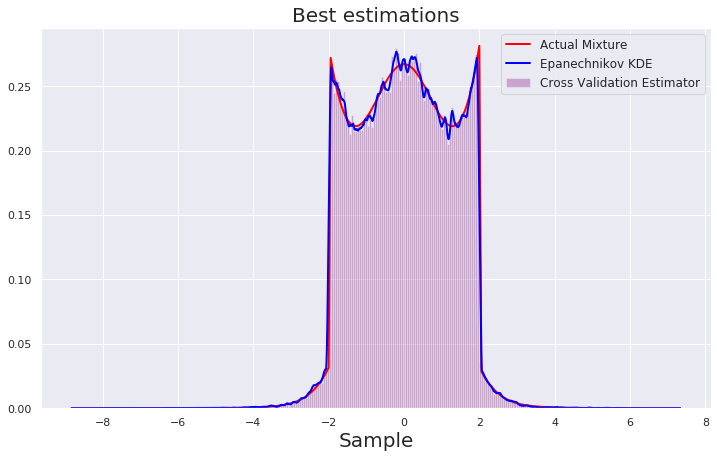

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.hist(X, bins=shared_bins, density=True, color="purple", alpha=0.3, label="Cross Validation Estimator")
ax.plot(shared_bins, mixture(shared_bins), color="red", linewidth=2, label="Actual Mixture")
ax.plot(X, dens, color="blue", linewidth=2, label="Epanechnikov KDE")
ax.set_xlabel("Sample", fontsize=20)
ax.set_title("Best estimations", fontsize=20)
ax.legend(fontsize=12)

# fig.savefig("Images/Task2_4.png", dpi=300)

# Task 3

In [174]:
def drawn_bs_mixture(n):    
    mixture = np.random.choice(6, n, p=[0.5, 0.1, 0.1, 0.1, 0.1, 0.1])

    X = []
    for i in range(n):
        if mixture[i] == 0:
            X.append(np.random.normal(0, 1))
        elif mixture[i] == 1:
            X.append(np.random.normal(-1, 1/10))
        elif mixture[i] == 2:
            X.append(np.random.normal(-1/2, 1/10))
        elif mixture[i] == 3:
            X.append(np.random.normal(0, 1/10))
        elif mixture[i] == 4:
            X.append(np.random.normal(1/2, 1/10))
        else: #mixture[i] == 5
            X.append(np.random.normal(1, 1/10))

    return np.array(X)

def bs_mixture(x):
    sigma = 1 / 10
    mixture = (
        0.5 * (1 / np.sqrt((2 * np.pi))) * np.exp(-0.5 * x**2) + 
        0.1 * (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-0.5 * (x + 1)**2 / sigma**2) + 
        0.1 * (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-0.5 * (x + 0.5)**2 / sigma**2) +
        0.1 * (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-0.5 * x**2 / sigma**2) +
        0.1 * (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-0.5 * (x - 0.5)**2 / sigma**2) +
        0.1 * (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-0.5 * (x - 1)**2 / sigma**2)
    )
    
    return mixture

In [128]:
X = np.sort(drawn_bs_mixture(n=100000))

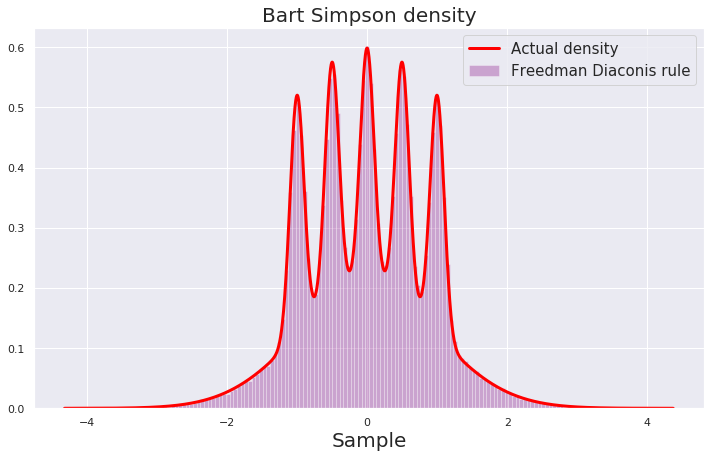

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

_ = ax.hist(X, bins="fd", density=True, color="purple", alpha=0.3, label="Freedman Diaconis rule")
ax.plot(X, bs_mixture(X), label="Actual density", color="red", linewidth=3)
ax.set_xlabel("Sample", fontsize=20)
ax.set_title("Bart Simpson density", fontsize=20)
ax.legend(fontsize=15)
# fig.savefig("Images/Task3_1.png", dpi=200)

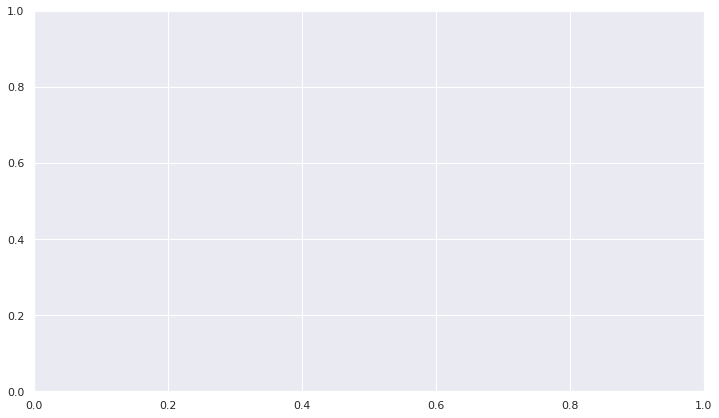

In [202]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

for n_components in range(2, 11):
    model = GaussianMixture(n_components=n_components)
    model.fit(X[:, None])
    y = np.exp(model.score_samples(X[:, None]))

    ax.plot(X, y, label=f"n_components = {n_components}", color="purple")
    ax.plot(X, bs_mixture(X), label="Actual density", ls="--", color="red", linewidth=2)
    ax.legend(fontsize=15)
    ax.set_xlabel("Sample", fontsize=20)
    ax.set_ylabel("Mixture Estimation", fontsize=20)
    ax.set_ylim([0, 0.6])
    ax.set_title(f"max log-likelihood = {round(model.lower_bound_, 3)}", fontsize=20)
    fig.savefig(f"Images/GIF_Images1/image_{n_components}.png")
    ax.clear()

In [203]:
def create_gif(fp_in, fp_out):
    img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
    img.save(fp=fp_out, format='GIF', append_images=imgs, 
             save_all=True, duration=600, loop=0)

fp_in = "Images/GIF_Images1/image_*.png"
fp_out = "Images/Task3_2.gif"
create_gif(fp_in, fp_out)

## Choose optimal bandwidth

In [222]:
X = np.sort(drawn_bs_mixture(n=2000))
dens_u = sm.nonparametric.KDEMultivariate(data=[X], var_type='c', bw="cv_ml")
opt_bandwidth = dens_u.bw[0]

/home/vitaliy/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kernel_density.py:161: RuntimeWarning: invalid value encountered in log
  L += func(f_i)


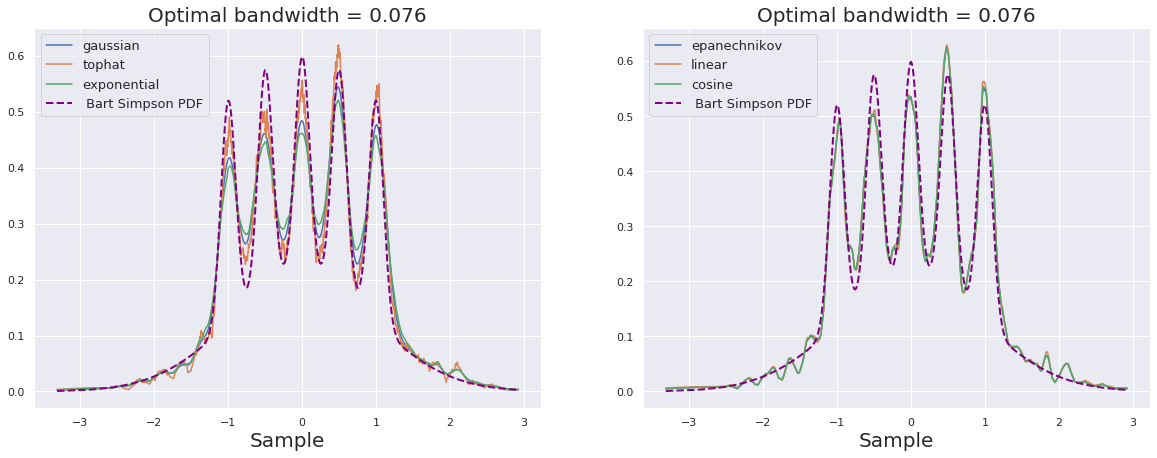

In [259]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
kernels = ["gaussian", "tophat", "exponential", "epanechnikov", "linear", "cosine"]

for kernel in kernels:
    kde = KernelDensity(kernel=kernel, bandwidth=opt_bandwidth).fit(X[:, None])
    dens = np.exp(kde.score_samples(X[:, None]))
    
    if kernel in ["gaussian", "tophat", "exponential"]:
        ax[0].plot(X, dens, label=kernel)
    else:
        ax[1].plot(X, dens, label=kernel)
        
ax[0].plot(X, bs_mixture(X), color="purple", linewidth=2, linestyle="--", label=" Bart Simpson PDF")
ax[0].set_xlabel("Sample", fontsize=20)
ax[0].set_title("Optimal bandwidth = {}".format(round(opt_bandwidth, 3)), fontsize=20)
ax[0].legend(fontsize=13, loc="upper left")

ax[1].plot(X, bs_mixture(X), color="purple", linewidth=2, linestyle="--", label=" Bart Simpson PDF")
ax[1].set_xlabel("Sample", fontsize=20)
ax[1].set_title("Optimal bandwidth = {}".format(round(opt_bandwidth, 3)), fontsize=20)
ax[1].legend(fontsize=13, loc="upper left")
# fig.savefig("Images/Task3_3.png", dpi=300)

## Choose n_components for EM-algorithm

We are going to minimize the next fucntional $\dfrac{1}{J} \sum \limits_{i=1}^J (\hat{p}_n^{EM}(x_i) - \hat{p}_n^{K}(x_i))^2 \rightarrow \min \limits_{\text{n_components}},$ w.r.t. Epanechnikov KDE.

In [253]:
kde = KernelDensity(kernel="epanechnikov", bandwidth=opt_bandwidth).fit(X[:, None])
dens = np.exp(kde.score_samples(X[:, None]))

MSE = []
for n_components in range(2, 11):
    model = GaussianMixture(n_components=n_components)
    model.fit(X[:, None])
    y = np.exp(model.score_samples(X[:, None]))
    
    MSE.append(sum((dens - y)**2) / len(X))

Text(0.5, 0, 'n_components')

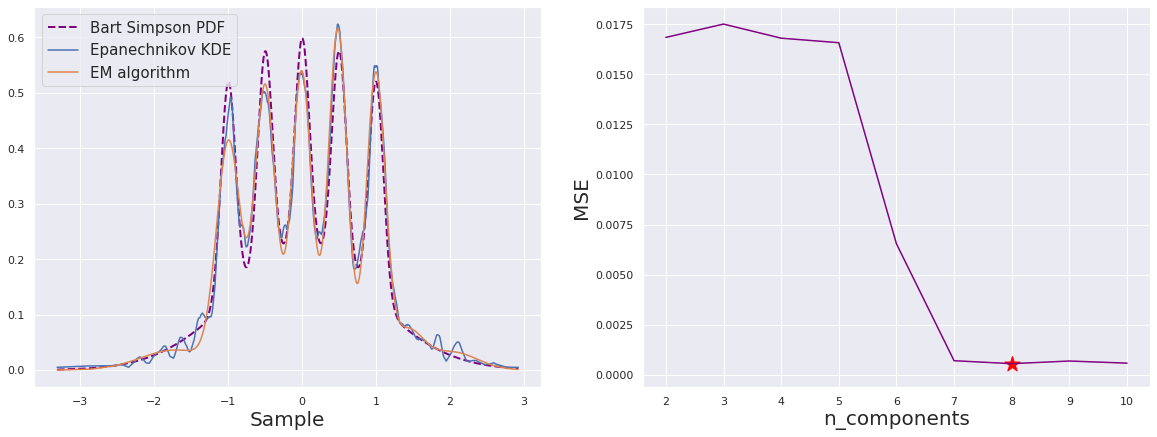

In [256]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

opt_n_components = 2 + np.argmin(MSE)

model = GaussianMixture(n_components=opt_n_components)
model.fit(X[:, None])
y = np.exp(model.score_samples(X[:, None]))

ax[0].plot(X, bs_mixture(X), label="Bart Simpson PDF", ls="--", color="purple", linewidth=2)
ax[0].plot(X, dens, label="Epanechnikov KDE")
ax[0].plot(X, y, label="EM algorithm")
ax[0].legend(fontsize=15)
ax[0].set_xlabel("Sample", fontsize=20)

ax[1].plot(np.arange(2, 11), MSE, color="purple")
ax[1].scatter(opt_n_components, MSE[opt_n_components - 2], color="red", marker="*", s=2**8)
ax[1].set_ylabel("MSE", fontsize=20)
ax[1].set_xlabel("n_components", fontsize=20)

# fig.savefig("Images/Task3_4.png")